In [2]:
from gluoncv import model_zoo, data, utils
import numpy as np
import cv2

class ObjectDetector:
    """
    Class used for detecting objects inside a given image
    
    Attributes
    ----------
    net : pretrained-model from gluoncv, using ssd architecture trained on the coco dataset.
    threshold : int - the threshold for the detections to be considered positive.
    """
    
    def __init__(self):
        self.net = model_zoo.get_model('ssd_512_mobilenet1.0_coco', pretrained=True)
        self.threshold = 0.5

    def get_bounding_box_coordinates(self,bounding_boxes,index):
        """
        Parameters
        ----------
        bounding_boxes = mxnet.NDarray(Nx4)list containing all the bounding_boxes coordinates
        index = int - the index of the wanted bounding-box
        
        Returns
        ----
        A pair of 4 items(c1,l1,c2,l2)describing the top left and bottom right corners of the bounding box
        """
        flat_bounding_box = bounding_boxes[index].asnumpy()
        c1 = int(flat_bounding_box.item(0))
        l1 = int(flat_bounding_box.item(1))
        c2 = int(flat_bounding_box.item(2))
        l2 = int(flat_bounding_box.item(3))
        return c1,l1,c2,l2
    
    
    def get_object_detections(self,image):
        """
        Method used for cropping the detected objects from the given image and returning the images
        reshaped to (64x64) and converted to grayscale for further processing by the autoencoder.
        
        Parameters
        ----------
        image = mxnet.NDarray - the image for which we want to extract the detections
        
        Returns
        ----
        np.array of size (NxWixHix1) where : 
        N = number of detections. 
        Wi = width of the i-th image. 
        Hi = height of the i-th image
        """ 
        x, img = data.transforms.presets.ssd.transform_test(image, short=512)
        print('Shape of pre-processed image:', x.shape)
        class_IDs, scores, bounding_boxes = self.net(x)
        detections = []
        counter = 0
        while (scores[0][counter] > self.threshold):
            try:
                c1,l1,c2,l2 = self.get_bounding_box_coordinates(bounding_boxes[0],counter)
                image = img[l1:l2,c1:c2]
                image = cv2.resize(image, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)
                image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
                detections.append(image)
            except cv2.error as e:
                print('Possible invalid bounding box :')
                print(l1,l2,c1,c2)
                print('Invalid detection! Shape of the invalid image :')
                print(image.shape)
            finally:
                counter = counter + 1
            
        return np.array(detections)
    

In [3]:
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model
from keras import backend as K
from keract import get_activations
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import SGD, Adam, RMSprop
from keras.callbacks import TensorBoard
import tensorflow as tf

class AutoEncoderModel:
    """
    Class used for creating autoencoders with the needed architecture .
    
    Attributes
    ----------
    autoencoder = the full autoencoder model, containing both the encoder and the decoder
    encoder = the encoder part of the autoencoder, sharing the weights with the autoencoder
    """
    def __init__(self, input_images,checkpoints_name):
        self.checkpoints_name = dataset_name
        self.checkpoint_dir = './checkpoints_%s' % self.checkpoints_name
        self.num_epochs = 100
        self.batch_size = 64
        self.autoencoder,self.encoder = self.__generate_autoencoder()
        self.__train_autoencoder(input_images)
        
    def __generate_autoencoder(self):
        input_img = Input(shape=(64, 64, 1))  
        x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
        x = MaxPooling2D((2, 2),strides=2, padding='same')(x)
        x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
        x = MaxPooling2D((2, 2),strides=2, padding='same')(x)
        x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
        encoded = MaxPooling2D((2, 2),strides=2, padding='same')(x)
        x = Conv2D(16, (3, 3), activation='relu', padding='same')(encoded)
        x = UpSampling2D((2, 2))(x)
        x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
        x = UpSampling2D((2, 2))(x)
        x = Conv2D(32, (3, 3), activation='relu', padding ='same')(x)
        x = UpSampling2D((2, 2))(x)
        decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)
        
        autoencoder = Model(input_img, decoded)
        encoder = Model(input_img,encoded)
        
        #compiling the models using Adam optimizer and mean squared error as loss
        optimizer = Adam(lr=10 ** -4)
        encoder.compile(optimizer=optimizer, loss='mse')
        autoencoder.compile(optimizer=optimizer, loss='mse')
        
        return autoencoder,encoder
    
    def __train_autoencoder(self,input_images):
        """
        Parameters 
        ----------
        
        input_images = np.array containing the 64x64x1 images used for training the autoencoder
        This images will serve as both training, and target data for the autoencoder.
        
        """
       
        if not os.path.exists(self.checkpoint_dir):
            os.makedirs(self.checkpoint_dir) 
            checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=self.checkpoint_dir + '/weights.hdf5', verbose=1, save_best_only=True)
            data_train, data_test, gt_train, gt_test = train_test_split(input_images, input_images, test_size=0.20, random_state=42)
            self.autoencoder.fit(data_train, gt_train,
                                epochs=self.num_epochs,
                                batch_size=self.batch_size,
                                shuffle=True,
                                validation_data=(data_test, gt_test),
                                callbacks = [checkpoint_callback])
        else:
            self.autoencoder.load_weights(self.checkpoint_dir + '/weights.hdf5') 
        
    def get_encoded_state(self,images):
        """
        Parameters
        ---------- 
        images - np.array containing the images that need to be encoded
        
        Returns
        -------
        np.array containing the encoded images, predicted by the encoder.
        """
        
        encodings = self.encoder.predict(images)
        return encodings
    

Using TensorFlow backend.


In [4]:
class VideoProcessor:
    """
    Class used for reading a processing a video
    The scope is to obtain all the detected objects in all the frames toghether with their computed gradient.
    
    Attributes
    ----------
    detected_objects - np.array 
    object_gradients - np.array containing the corresponding gradients

    """
    
    def __init__ (self, video_path):
        self.__video_path = video_path
        self.__video = cv2.VideoCapture(video_path)
        self.__detected_objects, self.__object_gradients = self.__process_video(self.__video)
        
    def __process_video(self, video):
        gradients = []
        objects = []
        while True:
            ret, frame = video.read()
            if ret == 0:
                break
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            frame = mx.nd.array(frame)
            frame = frame.astype(np.uint8)
            object_detector = ObjectDetector()
            detections = object_detector.get_object_detections(frame)
            for image in detections:
                # Get x-gradient in "sx"
                sx = cv2.Sobel(image,cv2.CV_64F,1,0,ksize = 5)
                # Get y-gradient in "sy"
                sy = cv2.Sobel(image,cv2.CV_64F,0,1,ksize = 5)
                # Get square root of sum of squares
                sobel=np.hypot(sx,sy)
                sobel = sobel.astype(np.float32)
                
                objects.append(np.resize(image,(64,64,1)))
                gradients.append(np.resize(image,(64,64,1)))
        return np.array(objects), np.array(gradients)
    
    def get_detected_objects(self):
        return self.__detected_objects
    
    def get_object_gradients(self):
        return self.__object_gradients
    def get_video(self):
        return self.__video
            



In [5]:
class DataSetTrainer:
    """
    Class used for wrapping up the training process on a specific dataset.
    Path of the directory that contains the training videos is needed in order to create a new instance.
    During initialization, the DataSetTrainer will proceed with full-stack training on the data,
    and at the end the inference phase will be available for the user to check test data.
    """
    
    def __init__(self,dataset_directory_path):
        self.total_objects,self.total_gradients = self.__get_objects_and_gradients(dataset_directory_path, verbose=1)     
        self.autoencoder_images = AutoEncoderModel(self.total_objects, 'raw_object_autoencoder')
        self.autoecoder_gradients = AutoEncoderModel(self.total_gradients, 'gradient_object_autoencoder')
        
    def __get_objects_and_gradients(self, dataset_directory_path, verbose = 0):    
        gradients = np.resize([],(0,64,64,1))
        objects = np.resize([],(0,64,64,1))
        
        for video_name in os.listdir(dataset_directory_path):
            print(video_name)
            video_path = os.path.join(dataset_directory_path,video_name)
            video_processor = VideoProcessor(video_path)
            detected_objects = video_processor.get_detected_objects()
            object_gradients = video_processor.get_object_gradients()
            gradients = np.concatenate((gradients, object_gradients))
            objects = np.concatenate((objects, detected_objects))
            if (verbose == 1):
                print('Number of detected objects in video:')
                print(detected_objects.shape)
                print('Total number of objects untill now :')
                print(objects.shape)
        return objects,gradients
 
        
        

In [6]:
import os
import sys
from matplotlib.image import imread
import mxnet as mx
from gluoncv import model_zoo, data, utils
from matplotlib import pyplot as plt
from scipy import ndimage

# Root directory of the project
ROOT_DIR = os.path.abspath("../")
# Directory of images to run detection on
IMAGE_DIR = os.path.join(ROOT_DIR, "images")
#get a random file name from the image_directory
demo_image_name = os.listdir(IMAGE_DIR)[0]
print(demo_image_name)
demo_img_path = os.path.join(IMAGE_DIR,demo_image_name)
print(demo_img_path)
image = imread(demo_img_path)
image = mx.nd.array(image)
image = image.astype(np.uint8)
object_detector = ObjectDetector()
detections = object_detector.get_object_detections(image)
for image in detections:
    plt.figure()
    plt.imshow(image,cmap='gray', vmin=0, vmax=255)
    # Get x-gradient in "sx"
    sx = cv2.Sobel(image,cv2.CV_64F,1,0,ksize = 5)
    # Get y-gradient in "sy"
    sy = cv2.Sobel(image,cv2.CV_64F,0,1,ksize = 5)
    # Get square root of sum of squares
    sobel=np.hypot(sx,sy)
    sobel = sobel.astype(np.float32)
    # Hopefully see some edges
    plt.figure()
    plt.imshow(sobel,cmap=plt.cm.gray)

2502287818_41e4b0c4fb_z.jpg
/home/george/Licenta/Licenta/Anomaly detection in video/images/2502287818_41e4b0c4fb_z.jpg


/home/george/anaconda3/lib/python3.7/site-packages/mxnet/gluon/block.py:1159: UserWarning: Cannot decide type for the following arguments. Consider providing them as input:
	data: None
  input_sym_arg_type = in_param.infer_type()[0]


Shape of pre-processed image: (1, 3, 771, 512)


In [7]:
# cel used for working with the Avenue dataset

import os
import sys
from matplotlib.image import imread
import mxnet as mx
from gluoncv import model_zoo, data, utils
from matplotlib import pyplot as plt
from scipy import ndimage

shared_detected_objects = []
# Root directory of the project
ROOT_DIR = os.path.abspath("../")
# Directory of images to run detection on
VIDEO_DIR = os.path.join(ROOT_DIR, "Avenue Dataset/training_videos")
#get a random file name from the image_directory
for video_name in os.listdir(VIDEO_DIR):
    if video_name != '12.avi':
        continue
    print(video_name)
    video_path = os.path.join(VIDEO_DIR,video_name)
    video_processor = VideoProcessor(video_path)
    detected_objects = video_processor.get_detected_objects()
    # to be erased
    shared_detected_objects = detected_objects
    #until here
    autoencoder = AutoEncoderModel(detected_objects)
    break

12.avi


/home/george/anaconda3/lib/python3.7/site-packages/mxnet/gluon/block.py:1159: UserWarning: Cannot decide type for the following arguments. Consider providing them as input:
	data: None
  input_sym_arg_type = in_param.infer_type()[0]


Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)


KeyboardInterrupt: 

In [46]:
autoencoder = AutoEncoderModel(shared_detected_objects)

Train on 1546 samples, validate on 387 samples
Epoch 1/5
1546/1546 [==============================] - ETA: 22s - loss: 4437.646 - ETA: 22s - loss: 5013.144 - ETA: 20s - loss: 4990.246 - ETA: 22s - loss: 5075.129 - ETA: 22s - loss: 5123.362 - ETA: 21s - loss: 5031.147 - ETA: 20s - loss: 4889.181 - ETA: 18s - loss: 4896.362 - ETA: 17s - loss: 4931.699 - ETA: 15s - loss: 4932.658 - ETA: 14s - loss: 4895.227 - ETA: 13s - loss: 4827.133 - ETA: 12s - loss: 4733.979 - ETA: 10s - loss: 4750.849 - ETA: 9s - loss: 4764.397 - ETA: 8s - loss: 4786.38 - ETA: 7s - loss: 4837.63 - ETA: 6s - loss: 4816.50 - ETA: 5s - loss: 4791.09 - ETA: 4s - loss: 4812.78 - ETA: 3s - loss: 4794.48 - ETA: 2s - loss: 4835.50 - ETA: 1s - loss: 4857.89 - ETA: 0s - loss: 4871.03 - 26s 17ms/step - loss: 4874.5284 - val_loss: 5209.1859
Epoch 2/5
1546/1546 [==============================] - ETA: 23s - loss: 5275.725 - ETA: 21s - loss: 4937.211 - ETA: 19s - loss: 4848.842 - ETA: 18s - loss: 4743.861 - ETA: 18s - loss: 4709.53

(1, 64, 64, 1)
(1, 8, 8, 16)
(1933, 64, 64, 1)
(0, 64, 64, 1)
(3866, 64, 64, 1)


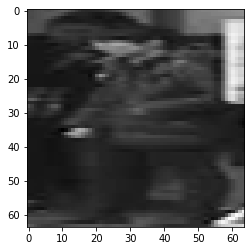

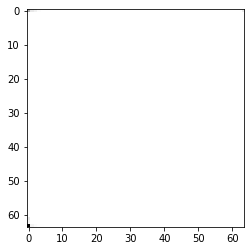

In [57]:
plt.figure()
plt.imshow(shared_detected_objects[0][:,:,0],cmap='gray')
plt.figure()
input = np.expand_dims(shared_detected_objects[0],axis=0)
print(input.shape)
plt.imshow(autoencoder.autoencoder.predict(input)[0][:,:,0],cmap = 'gray')
encoded_state = autoencoder.get_encoded_state(input)
print(encoded_state.shape)
print(shared_detected_objects.shape)
total_gradients = np.resize([],(0,64,64,1))
print(total_gradients.shape)
total_gradients = np.concatenate((total_gradients, shared_detected_objects))
total_gradients = np.concatenate((total_gradients, shared_detected_objects))
print(total_gradients.shape)

In [7]:

ROOT_DIR = os.path.abspath("../")
# Directory of images to run detection on
VIDEO_DIR = os.path.join(ROOT_DIR, "Avenue Dataset/training_videos")

dataset_trainer = DataSetTrainer(VIDEO_DIR)

02.avi
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape 

Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-

Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Possible invalid bounding box :
-2 499 194 446
Invalid detection! Shape of the invalid image :
(0, 252, 3)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Possible invalid bounding box :
-3 475 300 542
Invalid detection! Shape of the invalid image :
(0, 242, 3)
Shape of pre-processed image: (1, 

Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-

Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-

Shape of pre-processed image: (1, 3, 512, 910)
Possible invalid bounding box :
155 340 -2 78
Invalid detection! Shape of the invalid image :
(185, 0, 3)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
S

Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-

Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-

Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-

Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-

Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-

Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-

Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-

Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-

Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-

Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-

Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-

Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-

Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-

Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-

Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Possible invalid bounding box :
155 381 -1 79
Invalid detection! Shape of the invalid image :
(226, 0, 3)
Shape of pre-processed image: (1, 3, 512, 910)
Possible invalid bounding box :
154 382 -2 77
Invalid detection! Shape of the invalid image :
(228, 0, 3)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Possible invalid bounding box :
155 380 -1 70
Invalid detection! Shape of the invalid image :
(225, 0, 3)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Possible invalid bounding box :
144 364 -1 58
Invalid detection! Shape of the invalid image :
(220, 0, 3)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre

Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-

Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-

Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-

Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-

Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-processed image: (1, 3, 512, 910)
Shape of pre-

NameError: name 'total_objects' is not defined